In [441]:
from validator.InstanceCO22 import InstanceCO22
import warnings
from collections import OrderedDict
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
from util import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from vrpy import VehicleRoutingProblem
import pprint
sns.set()
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [442]:
instance = loadInstance(8)

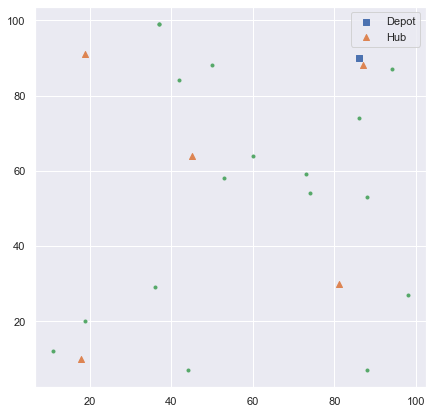

In [443]:
plotInstance(instance)

In [444]:
def locIDtoHubID(loc_ID):
    return loc_ID - 1

def hubIDtoLocID(hub_ID):
    return hub_ID + 1

In [445]:
def distance(loc1: InstanceCO22.Location, loc2: InstanceCO22.Location, ceil: bool = True) -> float:
    dist =  math.sqrt((loc1.X - loc2.X)**2 + (loc1.Y - loc2.Y)**2)
    if ceil:
        return math.ceil(dist)
    else:
        return dist

In [446]:
def closestHub(instance: InstanceCO22, location: InstanceCO22.Location) -> int:
    nHubs = len(instance.Hubs)
    hubs = instance.Locations[1:nHubs+1]
    minDist = math.inf
    minDistHubLocID = None
    for i, hub in enumerate(hubs):
        if location.ID in instance.Hubs[i].allowedRequests:
            hubDist = distance(location,hub)
            if hubDist < minDist:
                minDist = hubDist
                minDistHubLocID = hub.ID
    return minDistHubLocID


In [447]:
def locationsClosestHub(instance: InstanceCO22) -> dict:
    #return dictionary of {'LOC_ID': ' NEAREST LOC_ID'}
    res = {}
    for location in instance.Locations:
        res[location.ID] = closestHub(instance, location)
    return res

In [448]:
def locationsPerHub(instance: InstanceCO22) -> dict:
    closestHubPerLocation = locationsClosestHub(instance= instance)
    nHubs = len(instance.Hubs)
    hubLocIDs = list(range(2,nHubs+2))
    res = {val: [] for val in hubLocIDs}
    for hubLocID in hubLocIDs:
        for locID, closestHubLocID in closestHubPerLocation.items():
            if closestHubLocID is hubLocID:
                res[hubLocID].append(locID)
    return res


In [449]:
def amountPerProduct(instance: InstanceCO22, requests: list) -> list:
    nProducts = len(instance.Products)
    res = [None]*nProducts
    for i in range(nProducts):
        res[i] = sum([req.amounts[i] for req in requests])
    return res

In [450]:
locationsPerHub(instance)

{2: [2, 8, 13],
 3: [3, 7, 10, 14, 21],
 4: [1, 4, 15, 16],
 5: [5, 9, 12, 17, 20, 23],
 6: [6, 11, 18, 19, 22]}

In [451]:
def filterRequests(instance: InstanceCO22, day: int = None, locationsID: int = None) -> list:
    res = instance.Requests.copy()
    if day != None:
        res = [_ for _ in res if _.desiredDay is day]
    if locationsID != None:
        res = [_ for _ in res if _.customerLocID in locationsID]
    return res

In [452]:
def addAllEdges(G: nx.DiGraph) -> nx.DiGraph:
    for locID1, node1 in G.nodes(data=True):
        for locID2, node2 in G.nodes(data=True):
            if locID1 != locID2:
                dist = math.ceil( math.sqrt( pow(node1['X']-node2['X'],2) + pow(node1['Y']-node2['Y'],2) ))
                if locID1 == "Sink" or locID2 == "Source" or (locID1 == "Source" and locID2 == "Sink"):
                    continue
                else:
                    G.add_edge(locID1, locID2, time = dist, cost=dist)   
    return G        

In [453]:
def createNxHub(instance: InstanceCO22, hubLocID: int, requests: list) -> nx.DiGraph:
    G = nx.DiGraph()
    for req in requests:
        reqLoc = instance.Locations[req.customerLocID-1]
        G.add_node(req.ID, locID = reqLoc.ID, reqID = req.ID, X=reqLoc.X, Y=reqLoc.Y, demand = sum(req.amounts), amounts = req.amounts)
    hubLoc = instance.Locations[hubLocID]
    G.add_node("Source", locID = hubLocID, X=hubLoc.X, Y=hubLoc.Y)
    G.add_node("Sink",locID = hubLocID, X=hubLoc.X, Y=hubLoc.Y)
    G = addAllEdges(G)
    return G

[1, 4, 15, 16] [Id: 7 desiredDay 1 customerLocID15 amounts = 0,1,0,
, Id:10 desiredDay 1 customerLocID15 amounts = 9,0,7,
]
[7, 10, 'Source', 'Sink']


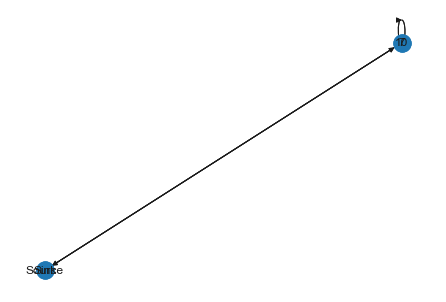

In [454]:
hubLocID = 4
locIDs = locationsPerHub(instance)[hubLocID]
requests = filterRequests(instance, day=1, locationsID=locIDs)
print(locIDs, requests)

G = createNxHub(instance, hubLocID, requests=requests)
pos = {id: (val['X'],val['Y']) for id,val in G.nodes(data=True)}
nx.draw(G, with_labels=True, pos = pos)
print(G.nodes())

In [455]:
def solveHubVRP(instance: InstanceCO22, hubLocID: int, requests: list) -> dict:
    #create networkX
    G = createNxHub(instance, hubLocID, requests)
    G_dict = {i:v for i,v in G.nodes(data=True)}
    #print(G_dict.keys())
    prob = VehicleRoutingProblem(G, load_capacity=instance.VanCapacity)
    prob.duration = instance.VanMaxDistance
    prob.fixed_cost = instance.VanDayCost
    prob.solve()
    best_routes = prob.best_routes
    #best_routes = {id:listReplace(best_routes[id], ["Source","Sink"], hubLocID) for id in best_routes.keys()}
    res =  {
        'routes': {key: {'route': [G_dict[id] for id in best_routes[key]]} for key in best_routes.keys()},
        'demand': sum([sum(req.amounts) for req in requests]),
        'amounts': amountPerProduct(instance, requests)
    }
    return res

In [456]:
%%capture
solveHubVRP(instance, 1, filterRequests(instance,day=1))

INFO:vrpy.vrp:new upper bound : max num stops = 12
INFO:vrpy.vrp:Clarke & Wright solution found with value 467 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 393 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 393.0
INFO:vrpy.vrp:iteration 1, 393.0
INFO:vrpy.vrp:iteration 2, 393.0
INFO:vrpy.vrp:iteration 3, 393.0
INFO:vrpy.vrp:iteration 4, 393.0
INFO:vrpy.vrp:iteration 5, 393.0
INFO:vrpy.vrp:iteration 6, 393.0
INFO:vrpy.vrp:iteration 7, 393.0
INFO:vrpy.vrp:iteration 8, 393.0
INFO:vrpy.vrp:iteration 9, 393.0
INFO:vrpy.vrp:iteration 10, 393.0
INFO:vrpy.vrp:iteration 11, 393.0
INFO:vrpy.vrp:iteration 12, 393.0
INFO:vrpy.vrp:iteration 13, 393.0
INFO:vrpy.vrp:iteration 14, 393.0
INFO:vrpy.vrp:iteration 15, 393.0
INFO:vrpy.vrp:iteration 16, 393.0
INFO:vrpy.vrp:iteration 17, 393.0
INFO:vrpy.vrp:iteration 18, 393.0
INFO:vrpy.vrp:iteration 19, 393.0
INFO:vrpy.vrp:iteration 20, 393.0
INFO:vrpy.vrp:iteration 21, 393.0
INFO:vrpy.master_solve_pulp:total cost = 393.0


In [457]:
def createNxDepot(instance: InstanceCO22, dayRoutes: dict) -> nx.DiGraph:
    G = nx.DiGraph()
    #add hubs
    for hubLocID, hubData in dayRoutes.items():
        G.add_node(hubLocID, locID = hubLocID, demand = hubData['demand'], amounts= hubData['amounts'], X=instance.Locations[hubLocID].X, Y=instance.Locations[hubLocID].Y)

    G.add_node("Source", locID=1, X = instance.Locations[0].X, Y = instance.Locations[0].Y)
    G.add_node("Sink", locID=1, X = instance.Locations[0].X, Y = instance.Locations[0].Y)

    G = addAllEdges(G)
    return G

In [458]:
def solveDepotVRP(instance: InstanceCO22, dayRoutes: dict) -> dict:
    #for solving per day
    G = createNxDepot(instance, dayRoutes)
    G_dict = {i:v for i,v in G.nodes(data=True)}
    print(G_dict.keys())

    prob = VehicleRoutingProblem(G, load_capacity=instance.TruckCapacity)
    prob.duration = instance.TruckMaxDistance
    prob.fixed_cost = instance.TruckDayCost
    prob.solve()
    best_routes = prob.best_routes
    #best_routes = {id:listReplace(best_routes[id], ["Source","Sink"], hubLocID) for id in best_routes.keys()}
    res =  {key: [G_dict[id] for id in best_routes[key]] for key in best_routes.keys()}
    return res

In [459]:
def solve(instance: InstanceCO22) -> dict:
    nDays = instance.Days
    nHubs = len(instance.Hubs)
    hubLocIDs = list(range(2,nHubs+2))
    hubClusters = locationsPerHub(instance)
    hubRoutes = {}  
    for day in range(1, nDays+1):                                                   #hub routing
        dayRoutes = {}
        for hubLocID in hubLocIDs:
            hubCluster = hubClusters[hubLocID]
            requestsToServe = filterRequests(instance, day, hubCluster)
            print(hubCluster, [_.ID for _ in requestsToServe])   #
            if(len(requestsToServe) > 0):
                dayHubRoutes = solveHubVRP(instance, hubLocID, requestsToServe)
                dayRoutes[hubLocID] = dayHubRoutes
        hubRoutes[day] = dayRoutes
    depotRoutes = {}
    for day in range(1, nDays+1):                                                   #depot routing
        res = solveDepotVRP(instance, hubRoutes[day])
        depotRoutes[day] = res

    return {'hubRoutes': hubRoutes, 'depotRoutes': depotRoutes}

In [460]:
%%capture
res = solve(instance)

INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 284 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 284 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 284.0
INFO:vrpy.master_solve_pulp:total cost = 284.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 186 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 186 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 186.0
INFO:vrpy.master_solve_pulp:total cost = 186.0
INFO:vrpy.vrp:new upper bound : max num stops = 5
INFO:vrpy.vrp:Clarke & Wright solution found with value 192 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 192 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 192.0
INFO:vrpy.vrp:iteration 1, 192.0
INFO:vrpy.vrp:iteration 2, 192.0
INFO:vrpy.vrp:iteration 3, 192.0
INFO:vrpy.vrp:iteration 4, 192.0
INFO:vrpy.master_solve_pulp:total cost = 192.0
INFO:vrpy.vrp:new upper bound : max num stops = 6
INFO:

In [461]:
print(pprint.pformat(res))

{'depotRoutes': {1: {1: [{'X': 86,
                          'Y': 90,
                          'collect': 0,
                          'demand': 0,
                          'frequency': 1,
                          'locID': 1,
                          'lower': 0,
                          'service_time': 0,
                          'upper': 0},
                         {'X': 87,
                          'Y': 88,
                          'amounts': [4, 9, 0],
                          'collect': 0,
                          'demand': 13,
                          'frequency': 1,
                          'locID': 3,
                          'lower': 0,
                          'service_time': 0,
                          'upper': 0},
                         {'X': 81,
                          'Y': 30,
                          'amounts': [10, 2, 13],
                          'collect': 0,
                          'demand': 25,
                          'frequency': 1,
       

In [462]:
def solutionToStr(instance: InstanceCO22, res: dict):
    resultString = "DATASET = CO2022_11 \n \n"

    for day in range(1, instance.Days+1):
        resultString += f"DAY = {day} \n"
        nTrucks = len(res['depotRoutes'][day])
        resultString += f"NUMBER_OF_TRUCKS = {nTrucks} \n"

        truckString = ""
        for routeID, truckRoute in res['depotRoutes'][day].items():
            truckString += f"{routeID} "
            for i, hubData in enumerate(truckRoute[1:-1]):
                amountPerProduct = hubData['amounts']
                truckString += f"H{hubData['locID'] - 1} {','.join([str(_) for _ in amountPerProduct])} "
            truckString += "\n"
        resultString += truckString

        nVans = 0
        i = 0
        vanString = ""
        for hubLocID in res['hubRoutes'][day].keys():
            for _, route in res['hubRoutes'][day][hubLocID]['routes'].items():
                i+=1
                reqIds = [_['reqID'] for _ in route['route'][1:-1] ]
                vanString += f"{i} H{hubLocID-1} {' '.join([str(_) for _ in reqIds])} \n"
            nVans += len(res['hubRoutes'][day][hubLocID]['routes'])
        resultString += f"NUMBER_OF_VANS = {nVans} \n"  
        resultString += vanString + "\n"
    return resultString
    

In [463]:
solutionStr = solutionToStr(instance,res)
with open("./solution_test_alg1.txt" ,'w') as file:
    file.write(solutionStr)


In [464]:
#assign hub to locations
#for each day, for each hub:
    #get request for hub, day
    #turn into networkX graph
    #solve using vrpy
    #store results
